# ES Controller : Paper Implementation

Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## High and Low Pass Filters

In [5]:

class Low_pass_filter_first_order:
    def __init__(self, sampling_period, cutoff_frequency_rad_per_s, initial_value):
        self.previous_value = initial_value
        self.coefficient = np.exp(-sampling_period * cutoff_frequency_rad_per_s)
        return

    def apply(self, input):
        if self.coefficient <= 0.0:  # no filtering
            self.previous_value = input
            return input
        output = self.coefficient * self.previous_value + (1 - self.coefficient) * input
        self.previous_value = output
        return output


class High_pass_filter_first_order:
    def __init__(
        self, sampling_period, cutoff_frequency_rad_per_s, initial_input, initial_output
    ):
        self.dt = sampling_period
        self.wc = cutoff_frequency_rad_per_s
        # output coefficient
        self.a1 = self.dt * self.wc + 2
        # input coefficient
        self.b1 = self.dt * self.wc - 2
        # prior input
        self.u_prev = initial_input
        # prior output
        self.y_prev = initial_output
        return

    def apply(self, input):
        output = 1.0 / self.a1 * (-self.b1 * self.y_prev + 2 * (input - self.u_prev))
        self.u_prev = input
        self.y_prev = output
        return output

## Es-Controller Module

In [6]:
# import numpy as np
# from first_order_filters import (
#     Low_pass_filter_first_order,
#     High_pass_filter_first_order,
# )


class esc:
    # cutoff_frequencies in rad/s
    def __init__(
        self,
        sampling_period,
        disturbance_frequency,
        disturbance_magnitude,
        integrator_gain,
        initial_search_value,
        high_pass_cutoff_frequency,
        low_pass_cutoff_frequency,
        use_adapter,
    ):
        self.dt = sampling_period  # in [s]
        self.disturbance_frequency = disturbance_frequency  # in rad/s
        self.disturbance_magnitude = disturbance_magnitude
        # negative for gradient descent
        self.integrator_gain = integrator_gain
        self.initial_search_value = initial_search_value
        # boolean, true or false (use the adapter or not)
        self.use_adapter = use_adapter

        self.high_pass_filter = High_pass_filter_first_order(
            sampling_period, high_pass_cutoff_frequency, 0, 0
        )
        self.low_pass_filter = Low_pass_filter_first_order(
            sampling_period, low_pass_cutoff_frequency, 0
        )
        # current phase of perturbation
        self.wt = 0
        # integrator output
        self.integral = 0
        # estimated second moment
        self.m2 = 0
        self.b2 = 0.9
        # to prevent from dividing by zero
        self.epsilon = 1e-8

        return

    def update(self, cost):
        high_pass_output = self.high_pass_filter.apply(cost)
        low_pass_input = high_pass_output * np.sin(self.wt)
        low_pass_output = self.low_pass_filter.apply(low_pass_input)
        gradient = 0

        if self.use_adapter:
            self.m2 = self.b2 * self.m2 + (1 - self.b2) * np.power(low_pass_output, 2)
            if np.sqrt(self.m2) > 1:
                gradient = low_pass_output / (np.sqrt(self.m2) + self.epsilon)
            else:
                gradient = low_pass_output * np.sqrt(self.m2)

        else:
            gradient = low_pass_output

        self.integral += self.integrator_gain * gradient * self.dt
        setpoint = self.initial_search_value + self.integral
        output = self.disturbance_magnitude * np.sin(self.wt) + setpoint
        perturbation = self.disturbance_magnitude * np.sin(self.wt)

        # update wt
        self.wt += self.disturbance_frequency * self.dt
        if self.wt > 2 * np.pi:
            self.wt -= 2 * np.pi

        return (
            output,
            high_pass_output,
            low_pass_output,
            (np.sqrt(self.m2) + self.epsilon),
            gradient,
            setpoint,
        )

## Simulator

In [19]:
# PLots

def plots(time_log, speed_setpoint_log, speed_es_output_log, speed_gradient_log, speed_m2_sqrt_log, sideslip_gradient_log, sideslip_m2_sqrt_log, speed_high_pass_output_log, speed_low_pass_output_log, sideslip_high_pass_output_log, sideslip_low_pass_output_log, sideslip_setpoint_log ):
    
    # Generate plots

    fig, ax = plt.subplots(6, 1, sharex=True)

    ax[0].plot(time_log, speed_setpoint_log, "b--", label="setpoint")
    ax[0].plot(time_log, speed_es_output_log, "b", label="output")
    ax[0].set_ylabel("speed [m/s]")
    ax[0].legend()

    ax[1].plot(time_log, sideslip_setpoint_log * 180 / np.pi, "r--", label="setpoint")
    ax[1].plot(time_log, sideslip_es_output_log * 180 / np.pi, "r", label="output")
    ax[1].set_ylabel("sideslip [deg]")
    ax[1].legend()

    ax[2].plot(time_log, cost_log)
    ax[2].set_ylabel("cost")

    ax[3].plot(time_log, speed_gradient_log, "b", label="speed gradient")
    ax[3].plot(time_log, speed_m2_sqrt_log, "b--", label="speed sqrt m2")
    ax[3].plot(time_log, sideslip_gradient_log, "r", label="ssg radient")
    ax[3].plot(time_log, sideslip_m2_sqrt_log, "r--", label="ss sqrt m2")
    ax[3].legend()

    ax[4].plot(time_log, speed_high_pass_output_log, "b", label="speed hp out")
    ax[4].plot(time_log, speed_low_pass_output_log, "b--", label="speed lp out")
    ax[4].legend()

    ax[5].plot(time_log, sideslip_high_pass_output_log, "r", label="ss hp out")
    ax[5].plot(time_log, sideslip_low_pass_output_log, "r--", label="ss lp out")
    ax[5].legend()

    ax[-1].set_xlabel("time [s]")
    plt.show()

NameError: name 'sideslip_es_output_log' is not defined

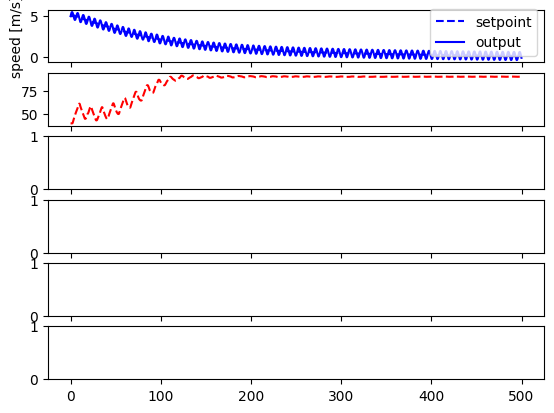

In [ ]:
from matplotlib.pyplot import plot


def cost_function(speed, sideslip):
    return 100 + speed**2 + 50 * np.power(sideslip - np.pi / 2, 2)


def run_simulation():

    # Simulation Setup
    dt = 0.02
    end_time = 500.0

    init_speed = 5.0  # in m/s
    init_sideslip = 40 * np.pi / 180  # in deg

    speed_disturbance_magnitude = 0.5  # [m/s]
    speed_frequency = 1.0  # [rad/s]
    sideslip_disturbance_magnitude = 7.5 * np.pi / 180
    sideslip_frequency = 0.5  # [rad/s]
    integrator_gain = -0.05
    step_num = int(end_time / dt)

    # Construct controller
    speed_extremum_seeking = esc(
        dt,
        speed_frequency,
        speed_disturbance_magnitude,
        integrator_gain,
        init_speed,
        speed_frequency,
        speed_frequency,
        True,
    )
    sideslip_extremum_seeking = esc(
        dt,
        sideslip_frequency,
        sideslip_disturbance_magnitude,
        integrator_gain,
        init_sideslip,
        sideslip_frequency,
        sideslip_frequency,
        True,
    )

    # Logging data
    time_log = np.zeros((step_num, 1))
    cost_log = np.zeros((step_num, 1))

    speed_es_output_log = np.zeros((step_num, 1))
    speed_high_pass_output_log = np.zeros((step_num, 1))
    speed_low_pass_output_log = np.zeros((step_num, 1))
    speed_m2_sqrt_log = np.zeros((step_num, 1))
    speed_gradient_log = np.zeros((step_num, 1))
    speed_setpoint_log = np.zeros((step_num, 1))

    sideslip_es_output_log = np.zeros((step_num, 1))
    sideslip_high_pass_output_log = np.zeros((step_num, 1))
    sideslip_low_pass_output_log = np.zeros((step_num, 1))
    sideslip_m2_sqrt_log = np.zeros((step_num, 1))
    sideslip_gradient_log = np.zeros((step_num, 1))
    sideslip_setpoint_log = np.zeros((step_num, 1))

    t = 0
    current_speed = init_speed
    current_sideslip = init_sideslip
    cost_init = cost_function(init_speed, init_sideslip)
    for i in range(step_num):
        cost = cost_function(current_speed, current_sideslip)
        [
            speed_es_output,
            speed_high_pass_output,
            speed_low_pass_output,
            speed_m2_sqrt,
            speed_gradient,
            speed_setpoint,
        ] = speed_extremum_seeking.update(cost - cost_init)
        [
            sideslip_es_output,
            sideslip_high_pass_output,
            sideslip_low_pass_output,
            sideslip_m2_sqrt,
            sideslip_gradient,
            sideslip_setpoint,
        ] = sideslip_extremum_seeking.update(cost - cost_init)

        # log data
        time_log[i] = t
        cost_log[i] = cost
        speed_es_output_log[i] = current_speed
        speed_high_pass_output_log[i] = speed_high_pass_output
        speed_low_pass_output_log[i] = speed_low_pass_output
        speed_m2_sqrt_log[i] = speed_m2_sqrt
        speed_gradient_log[i] = speed_gradient
        speed_setpoint_log[i] = speed_setpoint
        sideslip_es_output_log[i] = current_sideslip
        sideslip_high_pass_output_log[i] = sideslip_high_pass_output
        sideslip_low_pass_output_log[i] = sideslip_low_pass_output
        sideslip_m2_sqrt_log[i] = sideslip_m2_sqrt
        sideslip_gradient_log[i] = sideslip_gradient
        sideslip_setpoint_log[i] = sideslip_setpoint

        t += dt
        current_speed = speed_es_output
        current_sideslip = sideslip_es_output
    
    plots(time_log, speed_setpoint_log, speed_es_output_log, speed_gradient_log, speed_m2_sqrt_log, sideslip_gradient_log, sideslip_m2_sqrt_log, speed_high_pass_output_log, speed_low_pass_output_log, sideslip_high_pass_output_log, sideslip_low_pass_output_log, sideslip_setpoint_log, sideslip_es_output_log )


if __name__ == "__main__":
    run_simulation()